In [5]:
from generate_data import wave_util, wave_propagation, postprocess_wave
from skimage.transform import resize
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)
plt.rcParams['font.size'] = '14'

In [6]:
# set up models
import torch
from models import model_tiramisu
from models import model_unet

#unet model setup
#unet_model = unet.UNet(wf=1, depth=3, scale_factor=2)
unet_model = model_unet.UNet(depth=6, wf=1, acti_func='relu', scale_factor=4)
#unet_model = torch.nn.DataParallel(unet_model)
unet_model.load_state_dict(torch.load('../results/run_1/saved_model_unet256_10.pt'))
unet_model.eval()
unet_model = unet_model.double()

#tiramisu model setup
tir_model = model_tiramisu.FCDenseNet(scale_factor=4)
tir_model = torch.nn.DataParallel(tir_model)
#tir_model = unet2.UNet(depth=6, wf=1, acti_func='relu')
tir_model.load_state_dict(torch.load('../results/run_1/saved_model_tiramisu256_1.pt'))
tir_model.eval()
tir_model = tir_model.double()

netlist = [
    (r'unet 3lvl', unet_model),
    (r'tiramisu 55-55', tir_model)
]

for netname,netmodl in netlist:
    model_parameters = filter(lambda p: p.requires_grad, netmodl.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print(netname,'number of trainable parameters', params)

unet 3lvl number of trainable parameters 2561208
tiramisu 55-55 number of trainable parameters 691283


In [7]:
# parameter setup

Tf = 2.0
cT = 0.2
dx = 1.0/128.0
dt = dx / 20
ny, nx = 64, 64
m = 4
rt = 4
mt = round(Tf/cT)
t = np.linspace(0,Tf,mt)
x = np.arange(-1,1,dx)
y = np.arange(-1,1,dx)
xx,yy = np.meshgrid(x,y)

np.random.seed = 21
center = np.array([0.,0.])
# center_1 = np.array([-0.8,-0.8])
# u0_1 = np.exp(-250.0*(0.2*(xx-center_1[0])**2 + (yy-center_1[1])**2))*np.cos(8*np.pi*(yy-center_1[1]))
# center_2 = np.array([.8,.8])
# u0_2 = np.exp(-250.0*(0.2*(xx-center_2[0])**2 + (yy-center_2[1])**2))*np.cos(8*np.pi*(yy-center_2[1]))
# u0 = u0_1 + u0_2
u0 = np.exp(-250.0*(0.2*(xx-center[0])**2 + (yy-center[1])**2))*np.cos(8*np.pi*(yy-center[1]))
ut0 = np.zeros([np.size(xx,axis=1),np.size(yy,axis=0)])
vel = 1. + 0.0*yy - 0.5*(np.abs(yy+xx-0.)>0.4) + 0.*(np.abs(xx-0.4)<0.2)*(np.abs(yy-0.5)<0.1) #np.ones([np.size(xx,axis=1),np.size(yy,axis=0)]) #fig9 vel

veltest = (
   ('refrac',vel),
)

In [8]:
for velname, vel in veltest:

    #### Fine solution ####
    uf = np.zeros([xx.shape[0],xx.shape[1],mt])
    utf = np.zeros([xx.shape[0],xx.shape[1],mt])
    uf[:,:,0] = u0
    utf[:,:,0] = ut0
    for j in range(1,mt):
        uf[:,:,j],utf[:,:,j] = wave_propagation.velocity_verlet_time_integrator(uf[:,:,j-1],utf[:,:,j-1],vel,dx,dt,cT)

    #### Coarse solution ####
    ucc = np.zeros([xx.shape[0],xx.shape[1],mt])
    utcc = np.zeros([xx.shape[0],xx.shape[1],mt])
    ucc[:,:,0] = u0
    utcc[:,:,0] = ut0
    uc = resize(ucc[:,:,0],[ny,nx],order=4)
    utc = resize(utcc[:,:,0],[ny,nx],order=4)
    velc = resize(vel,[ny,nx],order=4)
    
    for j in range(1,mt):
        uc, utc = wave_propagation.velocity_verlet_time_integrator(uc,utc,velc,dx*m,dt*rt,cT)
        ucc[:,:,j] = resize(uc,[xx.shape[0],xx.shape[1]],order=4)
        utcc[:,:,j] = resize(utc,[xx.shape[0],xx.shape[1]],order=4)

    #### UNet solution ####
    unn1 = np.zeros([xx.shape[0],xx.shape[1],mt])
    utnn1 = np.zeros([xx.shape[0],xx.shape[1],mt])
    unn1[:,:,0] = u0
    utnn1[:,:,0] = ut0
    for j in range(1,mt):
        uc,utc = wave_propagation.velocity_verlet_time_integrator(resize(unn1[:,:,j-1],[ny,nx],order=4),
                             resize(utnn1[:,:,j-1],[ny,nx],order=4),
                             resize(vel,[ny,nx],order=4),dx*m,dt*rt,cT)
        unn1[:,:,j],utnn1[:,:,j] = postprocess_wave.ApplyJNet2WaveSol(uc,utc,vel,dx,unet_model,m)

    #### Tiramisu solution ####
    unn2 = np.zeros([xx.shape[0],xx.shape[1],mt])
    utnn2 = np.zeros([xx.shape[0],xx.shape[1],mt])
    unn2[:,:,0] = u0
    utnn2[:,:,0] = ut0
    for j in range(1,mt):
        uc,utc = wave_propagation.velocity_verlet_time_integrator(resize(unn2[:,:,j-1],[ny,nx],order=4),
                             resize(utnn2[:,:,j-1],[ny,nx],order=4),
                             resize(vel,[ny,nx],order=4),dx*m,dt*rt,cT)

        unn2[:,:,j],utnn2[:,:,j] = postprocess_wave.ApplyJNet2WaveSol(uc,utc,vel,dx,tir_model,m)

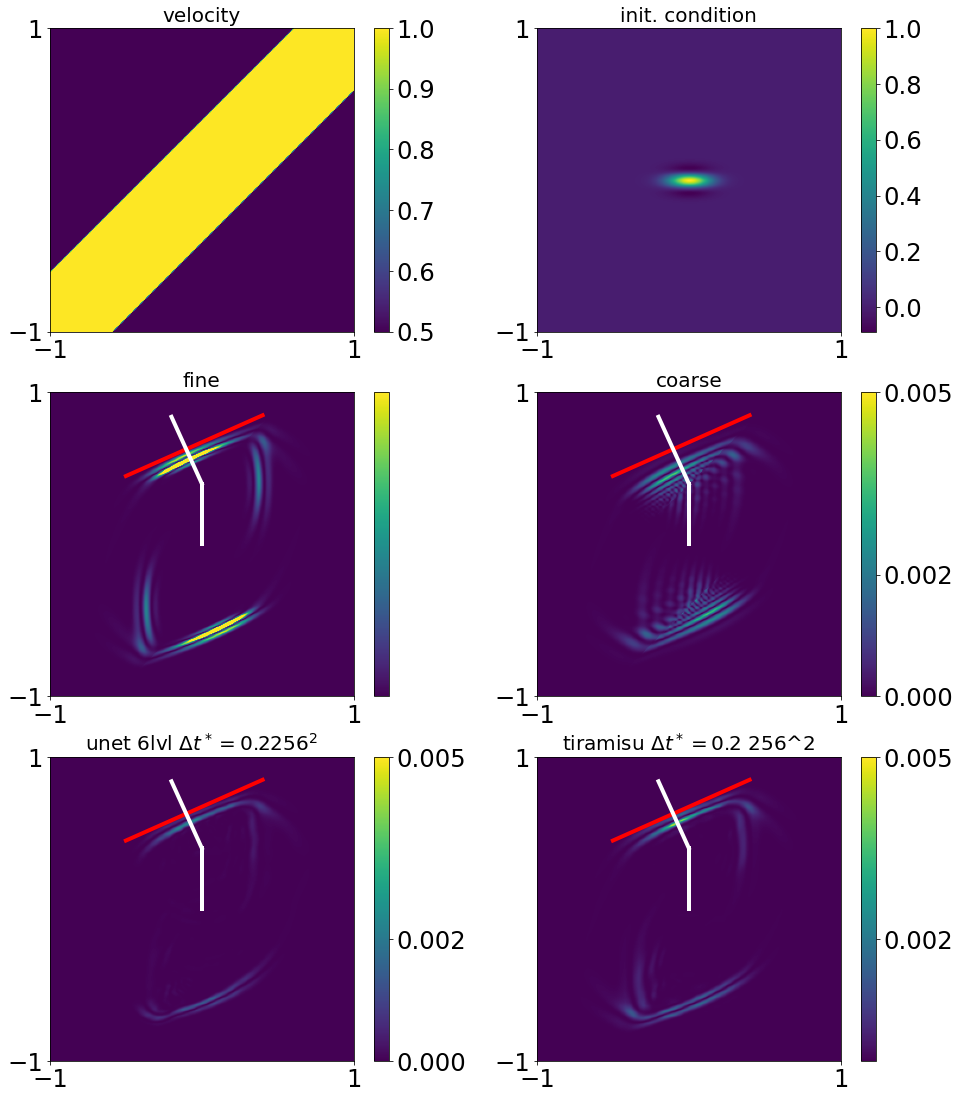

In [9]:
tj = 4
fig1 = plt.figure(figsize=(16,19))

ax1 = fig1.add_subplot(3,2,1)
pos1 = ax1.imshow(vel,extent=(-1,1,-1,1))
ax1.set_title('velocity', fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.colorbar(pos1)

ax2 = fig1.add_subplot(3,2,2)
pos2 = ax2.imshow(u0,extent=(-1,1,-1,1))
ax2.set_title('init. condition', fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.colorbar(pos2)

ax3 = fig1.add_subplot(3,2,3)
pos3 = ax3.imshow(wave_util.WaveEnergyField(uf[:,:,tj],utf[:,:,tj],vel,dx)*dx*dx,vmax=0.005,extent=(-1,1,-1,1))
ax3.set_title('fine', fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.plot([-0.5,0.4],[0.45,0.85],'r',linewidth=4)
plt.plot([0.,0.],[0.,0.4],'w',linewidth=4)
plt.plot([0.,-0.2],[0.4,0.84],'w',linewidth=4)
plt.colorbar(pos1,ticks = [0,0.002,0.005])

ax4 = fig1.add_subplot(3,2,4)
pos4 = ax4.imshow(wave_util.WaveEnergyField(ucc[:,:,tj],utcc[:,:,tj],vel,dx)*dx*dx,vmax=.005,extent=(-1,1,-1,1))
ax4.set_title('coarse', fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.plot([-0.5,0.4],[0.45,0.85],'r',linewidth=4)
plt.plot([0.,0.],[0.,0.4],'w',linewidth=4)
plt.plot([0.,-0.2],[0.4,0.84],'w',linewidth=4)
plt.colorbar(pos4,ticks = [0,0.002,0.005])

ax5 = fig1.add_subplot(3,2,5)
pos5 = ax5.imshow(wave_util.WaveEnergyField(unn1[:,:,tj],utnn1[:,:,tj],vel,dx)*dx*dx,vmax=.005,extent=(-1,1,-1,1))
ax5.set_title(r'unet 6lvl $\Delta t^*=0.2 256^2$', fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.plot([-0.5,0.4],[0.45,0.85],'r',linewidth=4)
plt.plot([0.,0.],[0.,0.4],'w',linewidth=4)
plt.plot([0.,-0.2],[0.4,0.84],'w',linewidth=4)
plt.colorbar(pos5,ticks = [0,0.002,0.005])

ax6 = fig1.add_subplot(3,2,6)
pos6 = ax6.imshow(wave_util.WaveEnergyField(unn2[:,:,tj],utnn2[:,:,tj],vel,dx)*dx*dx,vmax=0.005,extent=(-1,1,-1,1))
ax6.set_title(r'tiramisu $\Delta t^*=0.2$ 256^2', fontsize=20)
plt.xticks([-1,1])
plt.yticks([-1,1])
plt.plot([-0.5,0.4],[0.45,0.85],'r',linewidth=4)
plt.plot([0.,0.],[0.,0.4],'w',linewidth=4)
plt.plot([0.,-0.2],[0.4,0.84],'w',linewidth=4)
plt.colorbar(pos6, ticks = [0,0.002,0.005])

In [13]:
# compare wave energy norm errors:

from sklearn.metrics import mean_squared_error

for it in range(1,10):
    wf = wave_util.WaveEnergyField(uf[:,:,it], utf[:,:,it], vel, dx)*dx*dx
    w1 = wave_util.WaveEnergyField(unn1[:,:,it], utnn1[:,:,it], vel, dx)*dx*dx
    w2 = wave_util.WaveEnergyField(unn2[:,:,it], utnn2[:,:,it], vel, dx)*dx*dx

    mse1 = mean_squared_error(wf, w1)
    mse2 = mean_squared_error(wf, w2)

    print(it, mse1, mse2)

1 2.222971015433661e-07 8.832149092691034e-08
2 3.5725409319420366e-07 1.933508016532087e-07
3 3.45963532253423e-07 2.7905050801818685e-07
4 4.0802250862262545e-07 3.63439314263032e-07
5 4.1783613977965456e-07 3.973962301699262e-07
6 3.9512275344292934e-07 3.887815867524507e-07
7 3.65186823515949e-07 3.6404253018210757e-07
8 3.52860983284557e-07 3.510940906828868e-07
9 3.120940053791614e-07 3.1261906339902165e-07


In [11]:
'''
tiramisu128_10 outperforms unet128_9a with way less tuning parameters
training unet_128_9a and unet_128_9b is stable, and gives very similar results

tiramisu256_1 outperforms unet256_10 with way less tuning parameters, but similar training time (3x as much parameters)
'''

'\ntiramisu128_10 outperforms unet128_9a with way less tuning parameters\ntraining unet_128_9a and unet_128_9b is stable, and gives very similar results\n\ntiramisu256_1 outperforms unet256_10 with way less tuning parameters, but similar training time (3x as much parameters)\n'

In [ ]:
# def four_layers(x, y):
#     res = x + np.pi / 3.1 * y
#     if res < -1:
#         return .2
#     elif res < 0:
#         return .6
#     elif res < 1:
#         return .8
#     else:
#         return 1
#
# # four layers velocity
# dim = 128
# v_x = np.linspace(-1, 1, num=dim)
# v_y = np.linspace(-1, 1, num=dim)
# z = np.array([four_layers(i, j) for j in v_y for i in v_x])
# Z = np.array(z).reshape(dim, dim)
# vel = Z